- take a bunch of samples
  - either from training / validation / test set
  - either fully random generated from distribution similar to full dataset
- represent current state of neural network with those samples
  - flatten (and standardize) a distance matrix based on the last representation layer (colah thing)
    - head needs to be separated from last layer
  - take gradients
    - on the softmaxed outputs
    - flatten the same way
    - array valued uh oh

In [1]:
from typing import Generator, Mapping, Tuple
from itertools import product

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
import seaborn as sns
import tensorflow_datasets as tfds

from absl import app
from scipy.spatial import distance_matrix
from tqdm import tqdm
from umap import UMAP


In [2]:
plt.rcParams["figure.figsize"] = (15,7)

In [3]:
Batch = np.ndarray

In [4]:
def load_dataset(
    split: str,
    *,
    is_training: bool,
    batch_size: int,
) -> Generator[Batch, None, None]:
    """Loads the dataset as a generator of batches."""
    ds = tfds.load("mnist:3.*.*", split=split).cache().repeat()
    if is_training:
        ds = ds.shuffle(10 * batch_size, seed=0)
    return iter(tfds.as_numpy(ds.batch(batch_size)))

In [5]:
# Make datasets.
train = load_dataset("train", is_training=True, batch_size=1000)
train_eval = load_dataset("train", is_training=False, batch_size=10000)
test_eval = load_dataset("test", is_training=False, batch_size=10000)

In [6]:
jax.config.update('jax_platform_name', 'cpu')

jax.devices()

In [7]:
n_classes = 10

In [8]:
def head_fn(batch: jnp.ndarray):
    return hk.Sequential([jax.nn.relu, hk.Linear(n_classes), jax.nn.log_softmax])(batch)

In [9]:
def net_fn(batch: Batch) -> jnp.ndarray:
    """Standard LeNet-300-100 MLP network."""
    x = batch.astype(jnp.float32) / 255.0
    mlp = hk.Sequential(
        [
            hk.Flatten(),
            hk.Linear(300),
            jax.nn.relu,
            hk.Linear(100)]
    )
    return mlp(x)

In [10]:
def net_flip_fn(batch: Batch) -> jnp.ndarray:
    """Standard LeNet-300-100 MLP network."""
    x = batch.astype(jnp.float32) / 255.0
    mlp = hk.Sequential(
        [
            hk.Flatten(),
            hk.Linear(100),
            jax.nn.relu,
            hk.Linear(300),
        ]
    )
    return mlp(x)

In [11]:
def net_deeper_fn(batch: Batch) -> jnp.ndarray:
    """Standard LeNet-300-100 MLP network."""
    x = batch.astype(jnp.float32) / 255.0
    mlp = hk.Sequential(
        [
            hk.Flatten(),
            hk.Linear(70),
            jax.nn.relu,
            hk.Linear(140),
            jax.nn.relu,
            hk.Linear(70),
        ]
    )
    return mlp(x)

In [12]:
def loss(params: hk.Params, batch: Batch) -> jnp.ndarray:
    """Compute the loss of the network, including L2."""
    logits = net.apply(params, batch["image"])
    labels = jax.nn.one_hot(batch["label"], 10)

    l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))
    softmax_xent = -jnp.sum(labels * logits)
    softmax_xent /= labels.shape[0]

    return softmax_xent + 1e-4 * l2_loss

In [13]:
# Evaluation metric (classification accuracy).
@jax.jit
def accuracy(params: hk.Params, batch: Batch) -> jnp.ndarray:
    predictions = net.apply(params, batch["image"])
    return jnp.mean(jnp.argmax(predictions, axis=-1) == batch["label"])


In [14]:
@jax.jit
def update(
    params: hk.Params,
    opt_state: optax.OptState,
    batch: Batch,
) -> Tuple[hk.Params, optax.OptState]:
    """Learning rule (stochastic gradient descent)."""
    grads = jax.grad(loss)(params, batch)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

In [15]:
# We maintain avg_params, the exponential moving average of the "live" params.
# avg_params is used only for evaluation (cf. https://doi.org/10.1137/0330046)
@jax.jit
def ema_update(params, avg_params):
    return optax.incremental_update(params, avg_params, step_size=0.001)

In [16]:
gbs = 2010
gbn = 120
gbatch = next(train_eval)["image"].astype(np.float)[gbs : gbs + gbn, :]

In [17]:
# Initialize network and optimiser; note we draw an input to get shapes.

reprids = []
grad_reparrs = []
dist_reparrs = []
for f, mid in tqdm([*product([net_fn, net_deeper_fn, net_flip_fn], [*range(5)])]):
    model_name = f"mlp-{f.__name__}"

    def full_net(batch):
        return head_fn(f(batch))

    net = hk.without_apply_rng(hk.transform(full_net))
    params = avg_params = net.init(jax.random.PRNGKey(42 * mid), next(train)["image"])
    opt = optax.adam(1e-3)
    opt_state = opt.init(params)
    jacfun = jax.jacfwd(net.apply, argnums=1)
    for step in range(2701):
        if step % 300 == 0:
            # Periodically evaluate classification accuracy on train & test sets.
            train_accuracy = accuracy(avg_params, next(train_eval))
            test_accuracy = accuracy(avg_params, next(test_eval))
            train_accuracy, test_accuracy = jax.device_get(
                (train_accuracy, test_accuracy)
            )
            reprids.append(
                {
                    "step": step,
                    "model": model_name,
                    "mid": mid,
                    "train_acc": float(train_accuracy),
                    "test_acc": float(test_accuracy),
                }
            )
            pre_head = hk.without_apply_rng(hk.transform(f)).apply(params, gbatch)
            grad_reparrs.append(
                jax.vmap(lambda x: jacfun(params, x[np.newaxis, :]))(gbatch).reshape(
                    1, -1
                )
            )
            dist_reparrs.append(distance_matrix(pre_head, pre_head).reshape(1, -1))

        # Do SGD on a batch of training examples.
        params, opt_state = update(params, opt_state, next(train))
        avg_params = ema_update(params, avg_params)

100%|██████████| 15/15 [12:30<00:00, 50.04s/it]


In [18]:
repbase = pd.DataFrame(reprids)

In [19]:
repfilter = repbase["step"] > 0

In [21]:
distreparr = (lambda x: x / x.mean(axis=1).reshape(-1, 1))(np.concatenate(dist_reparrs))[repfilter,:]
gradreparr = np.concatenate(grad_reparrs)[repfilter,:]

In [22]:
gradmapper = UMAP().fit(gradreparr)
distmapper = UMAP().fit(distreparr)

In [23]:
repdf = pd.concat(
    [
        repbase.loc[repfilter, :].reset_index(drop=True),
        pd.DataFrame(gradmapper.transform(gradreparr), columns=["umap-x", "umap-y"]),
        pd.DataFrame(
            distmapper.transform(distreparr), columns=["umap-d-x", "umap-d-y"]
        ),
    ],
    axis=1,
)

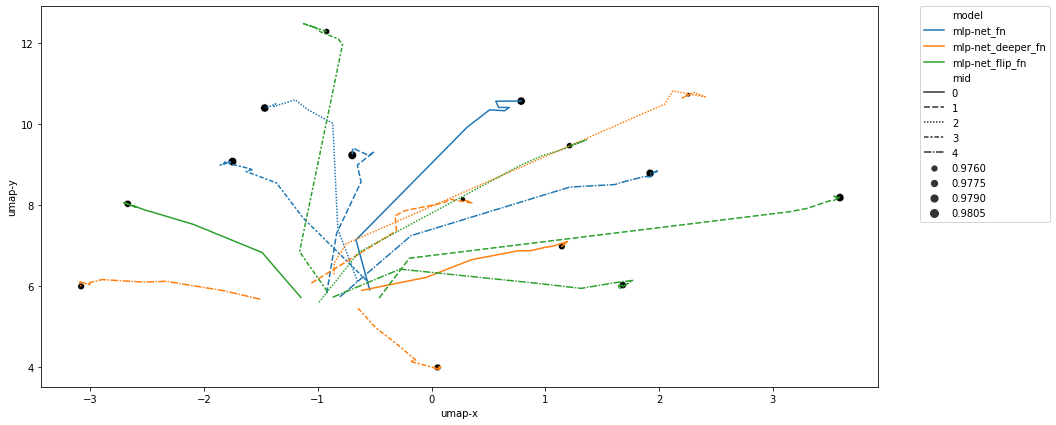

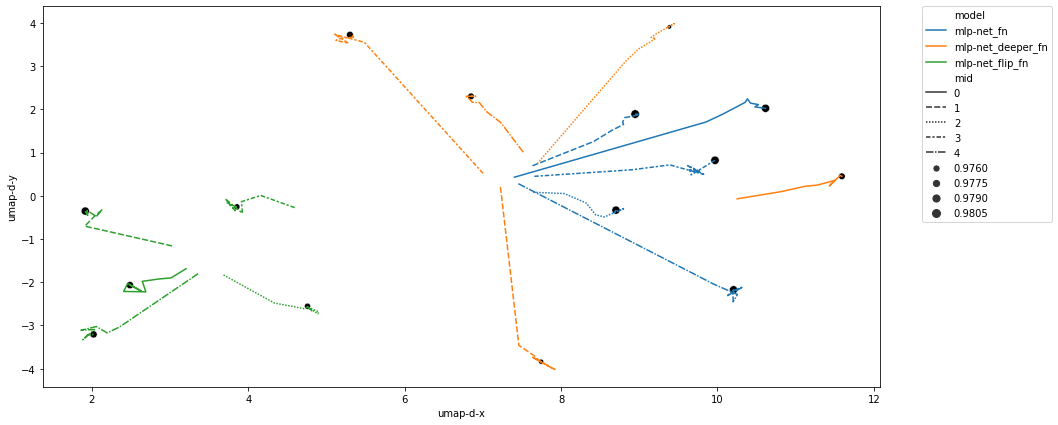

In [27]:
for plotaxs in [{"x": "umap-x", "y": "umap-y"}, {"x": "umap-d-x", "y": "umap-d-y"}]:
    ax = sns.lineplot(data=repdf, sort=False, hue="model", style="mid", **plotaxs)

    sns.scatterplot(
        data=repdf.groupby(["model", "mid"]).last().reset_index(),
        size="test_acc",
        ax=ax,
        # legend=False,
        color="black",
        **plotaxs
    )
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.show()